<a href="https://colab.research.google.com/github/Sugirlstar/GPU_griddedCalcualtion_draft/blob/main/SHPcrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install xarray
# install cuda
!curl https://colab.chainer.org/install | sh -

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1553  100  1553    0     0   6988      0 --:--:-- --:--:-- --:--:--  6995
sh: 9: nvidia-smi: not found
********************************************************************************
GPU is not enabled!
Open "Runtime" > "Change runtime type" and set "Hardware accelerator" to "GPU".
********************************************************************************


In [2]:
!pip install cartopy

import numpy as np
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point
from shapely.prepared import prep
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
# 加载shapefile
path_to_shp_file = "/content/drive/MyDrive/Colab Notebooks/ChinaPolygon.shp"
shp = gpd.read_file(path_to_shp_file)

# 加载NPZ文件
path_to_npz_file = "/content/drive/MyDrive/Colab Notebooks/ERA5Land_SPI_China_19691231_20221231.npz"
with np.load(path_to_npz_file) as data:
    arr1 = data['arr1']


In [4]:
# 将shapefile的坐标系转换为与NPZ文件相同的坐标系
crs_npz = "EPSG:4326"
shp = shp.to_crs(crs_npz)


In [5]:
# 合并所有几何体并预处理
prepared_geometry = prep(shp.geometry.unary_union)

# 为数组中的每个元素计算经纬度
lons = np.linspace(72, 136, 641)
lats = np.linspace(18, 54, 361)

# 创建一个与数组相同大小的布尔mask
mask = np.array([[prepared_geometry.contains(Point(lon, lat)) for lon in lons] for lat in lats])

arr_cropped=np.flip(arr1,axis=1)

# 使用mask更新arr2
for k in range(arr_cropped.shape[0]):
    arr_cropped[k, ~mask] = np.nan


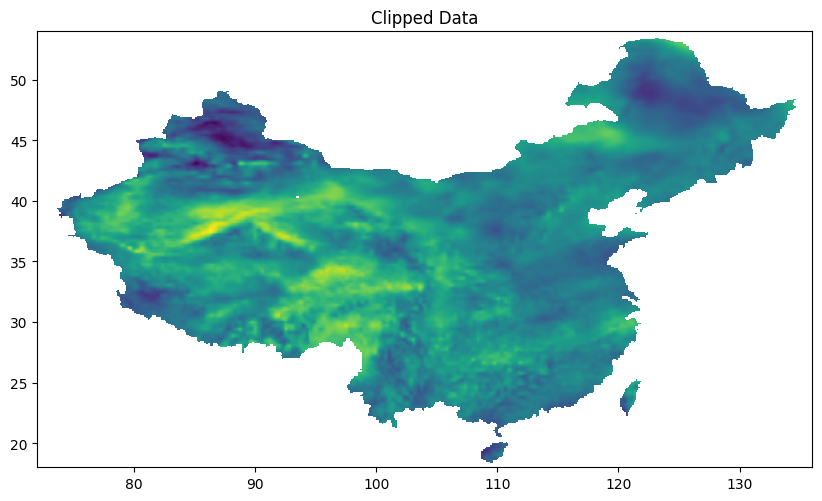

In [6]:
# 创建图像
fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(arr1[90,:,:], cmap='viridis',extent=(72,136,18,54))
plt.title('Clipped Data')
plt.show()

# 保存裁剪后的数据
# np.savez("path/to/output/clipped_data.npz", arr1=clipped_data)


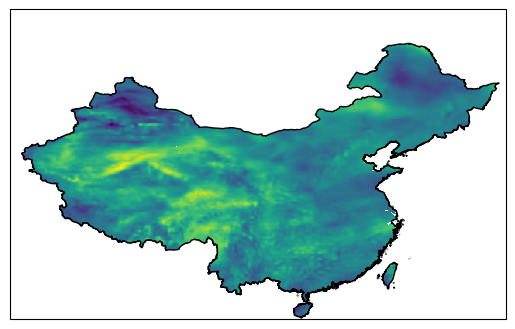

In [7]:

# 创建地图并叠加shp
lon = np.linspace(72, 136, 641)
lat = np.linspace(18, 54, 361)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([72, 136, 18, 54])  # 设置地图边界

# 绘制数组数据
ax.pcolormesh(lon, lat, arr_cropped[90,:,:], shading='auto', transform=ccrs.PlateCarree(), cmap='viridis')

# 叠加shp文件
ax.add_geometries(shp['geometry'], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

plt.show()



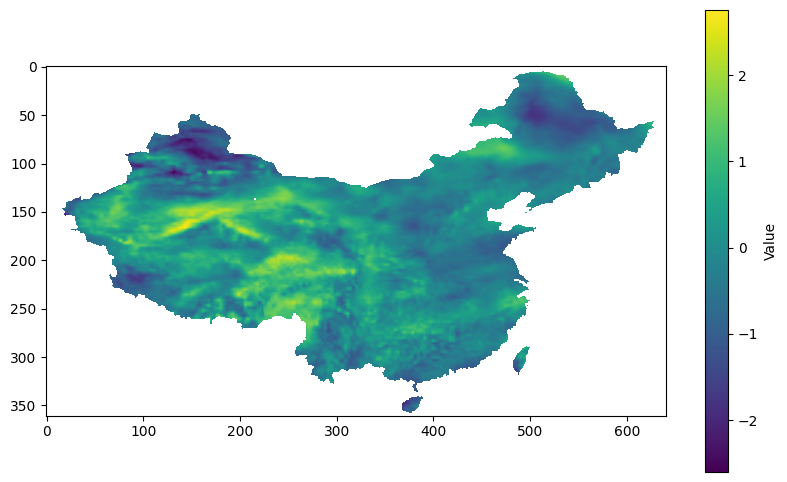

In [8]:
plt.figure(figsize=(10,6))
plt.imshow(arr1[90,:,:], cmap='viridis', origin='lower') #origin='lower'设置原点在左下角
plt.imshow(arr1[90,:,:], cmap='viridis', origin='upper') #origin='upper'设置原点在左上角
plt.colorbar(label="Value")
plt.show()